In [2]:
import osrs_GE

import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

In [140]:
# dragonfire shield
item_id = 11284
freq = '6h'

df = osrs_GE.read_item_master_file(item_id,freq)
df = osrs_GE.compute_VWAP(df)
df.head()

File read successfully for Master Files/items/master_file_11284_6h.csv


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP
date,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06


In [142]:
df['simpRet_y'] = df['VWAP'].shift(-1)/df['VWAP'] - 1
df.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet_y
date,,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06,-0.006633
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06,-0.047092
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06,0.000898
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06,0.005086
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06,-0.003957


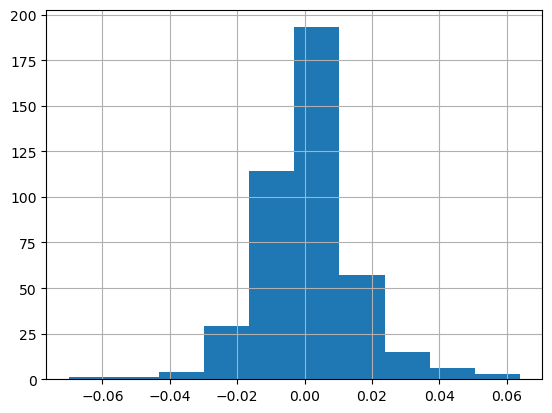

In [144]:
df['simpRet_y'].hist()
plt.show()

What features to include in forecasting price?
- order imbalance (+ lags)
- lagged returns
- TA indicators
  - RSI
  - MACD
  - SMA
  - LMA

In [147]:
### Creating features
#### parameters

RSI_window = 5
MACD_short = 3
MACD_long = 8

if freq == '6h':
    RSI_window = 10
    MACD_short = 4
    MACD_long = 16


##### RSI
df = osrs_GE.compute_RSI(df,window = RSI_window,col_name = 'VWAP')


##### Order Imbalance
df['OI'] = df['highPriceVolume'] -  df['lowPriceVolume']
df['OI*'] = df['OI']*((df['avgHighPrice'] > df['avgLowPrice'])*1 - (df['avgHighPrice'] < df['avgLowPrice']))
df['OI_ratio'] = df['OI']/(df['highPriceVolume'] + df['lowPriceVolume'])


##### Spread
df['Spread'] = df['avgHighPrice'] - df['avgLowPrice']
df['SpreadPct'] = df['Spread']/df['VWAP']


##### Cross Metric - interaction between the OI and the actively traded price spread
df['CM'] = df['SpreadPct']*df['OI']


##### MACD
df = osrs_GE.compute_MACD(df,st_n=MACD_short,lt_n=MACD_long, drop_ema_cols = False)
df['VWAP/ema'+str(MACD_short)] = df['VWAP']/df['VWAP_ema'+str(MACD_short)]
df['VWAP/ema'+str(MACD_long)] = df['VWAP']/df['VWAP_ema'+str(MACD_long)]
df['VWAP_nMACD_{0}_{1}'.format(MACD_short,MACD_long)] = df['VWAP_MACD_{0}_{1}'.format(MACD_short,MACD_long)]/df['VWAP']


df = df.drop(['timestamp','avgHighPrice','avgLowPrice','highPriceVolume',
            'lowPriceVolume','VWAP','VWAP_diff','OI*','Spread','VWAP_ema'+str(MACD_short),
            'VWAP_ema'+str(MACD_long),'VWAP_MACD_{0}_{1}'.format(MACD_short,MACD_long)],axis=1)

df = df.dropna()

df.head()

,simpRet_y,VWAP_RSI10,OI,OI_ratio,SpreadPct,CM,VWAP/ema4,VWAP/ema16,VWAP_nMACD_4_16
date,,,,,,,,,
2024-06-13 00:00:00,0.005685,28.204822,-3,-0.006160,0.010799,-0.032398,0.995829,0.989546,-0.006376
2024-06-13 06:00:00,-0.011487,28.792980,160,0.375587,0.006632,1.061199,1.000892,0.995900,-0.005009
2024-06-13 12:00:00,0.003358,47.990845,16,0.033755,0.016352,0.261632,0.993616,0.986705,-0.007049
2024-06-13 18:00:00,0.017145,51.113301,77,0.117199,0.016214,1.248510,0.998170,0.991427,-0.006814
2024-06-14 00:00:00,0.000640,62.258941,69,0.128015,0.018791,1.296571,1.009112,1.007246,-0.001835


In [149]:
df.shape

(413, 9)